# **Gender Classification**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.5 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=b93ca45d93b02042d3e0b5b53b87b1f89f0205f80a45cfa1e

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from efficientnet_pytorch import EfficientNet
from google.colab import drive
import torch.nn.functional as F
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import pandas as pd
from collections import Counter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dataset_dir = '/content/drive/MyDrive/Comys_Hackathon5/Task_A'

Using device: cuda


# **Data Augmentation**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=transform)
class_names = train_dataset.classes

In [ ]:
class_counts = Counter([label for _, label in train_dataset])
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_names))]
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# **Efficientnet model**

In [ ]:
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB4Classifier, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b4')
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1792, num_classes)
        )

    def forward(self, x):
        x = self.effnet.extract_features(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        return self.classifier(x)


In [ ]:
model = EfficientNetB4Classifier(num_classes=len(class_names)).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 116MB/s]


Loaded pretrained weights for efficientnet-b4


In [ ]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()

/tmp/ipython-input-16-1236668270.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


# **Training**

In [ ]:
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
early_stop_counter = 0
PATIENCE = 5

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1/30, Train Loss: 0.0311, Train Acc: 0.9803, Val Loss: 0.2232, Val Acc: 0.9336
Epoch 2/30, Train Loss: 0.0279, Train Acc: 0.9839, Val Loss: 0.3447, Val Acc: 0.9289
Epoch 3/30, Train Loss: 0.0159, Train Acc: 0.9933, Val Loss: 0.3762, Val Acc: 0.9336
Epoch 4/30, Train Loss: 0.0260, Train Acc: 0.9860, Val Loss: 0.3018, Val Acc: 0.9265
Epoch 5/30, Train Loss: 0.0159, Train Acc: 0.9886, Val Loss: 0.4719, Val Acc: 0.9147
Epoch 6/30, Train Loss: 0.0144, Train Acc: 0.9927, Val Loss: 0.4052, Val Acc: 0.9265
Early stopping triggered.


# **Train and Val graph**

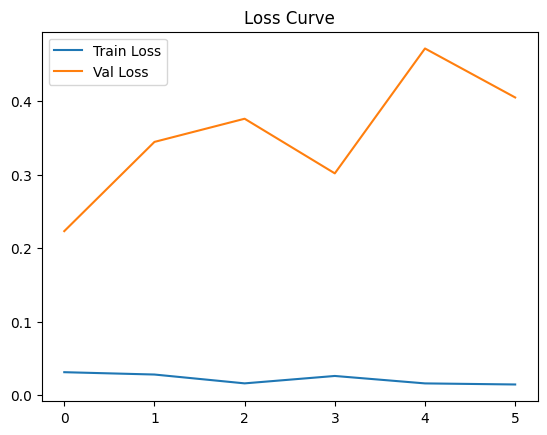

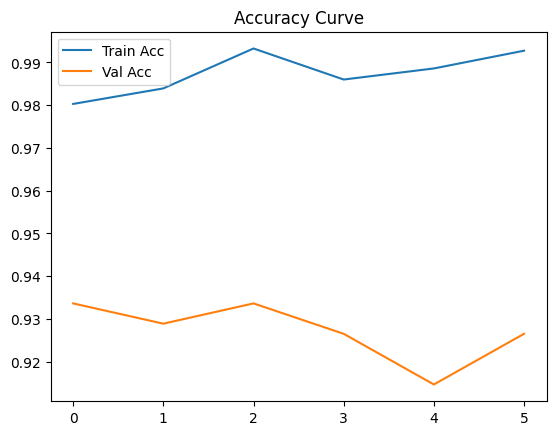

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()
plt.show()


# **Confusion matrix**

Classification Report:
              precision    recall  f1-score   support

      female       0.86      0.78      0.82        79
        male       0.95      0.97      0.96       343

    accuracy                           0.94       422
   macro avg       0.91      0.88      0.89       422
weighted avg       0.93      0.94      0.93       422



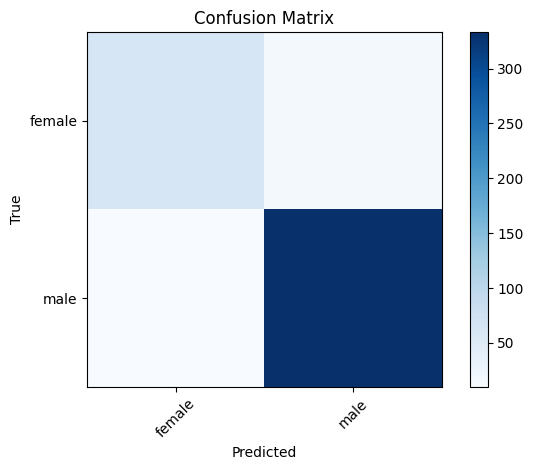

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()




# **CSV file**



In [ ]:
pred_df = pd.DataFrame({
    "true": [class_names[i] for i in all_labels],
    "pred": [class_names[i] for i in all_preds]
})
pred_df.to_csv("/content/drive/MyDrive/Comys_Hackathon5/Task_A/val_predictions.csv", index=False)
print("Saved predictions to CSV.")

Saved predictions to CSV.


# **Val Accuracy**

In [ ]:
acc = accuracy_score(all_labels, all_preds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")


Final Validation Accuracy: 93.60%


# **Test evaluation script**

In [ ]:
def evaluate_on_test(model_path, test_dir, class_names, device):
    test_transform = transforms.Compose([
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = EfficientNetB4Classifier(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    # Evaluation Metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print("\n📊 TEST SET EVALUATION RESULTS:")
    print(f"✅ Accuracy : {acc:.4f}")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"🔁 Recall   : {recall:.4f}")
    print(f"🏅 F1-score : {f1:.4f}")

# **Run this script to test it**

In [ ]:
evaluate_on_test(
    model_path="/content/drive/MyDrive/Comys_Hackathon5/Task_A/best_model.pth",
    test_dir="/content/drive/MyDrive/Comys_Hackathon5/Task_A/test",
    class_names=class_names,
    device=device
)